In [ ]:
import pandas as pd
import utilities
%matplotlib inline
%pylab

In [2]:
stages = pd.read_csv('Edge520Stages.csv')
vector = pd.read_csv('Edge800Vector.csv')

## Rename columns to get rid of UTF nonsense

In [3]:
## Rename columns Stages
stages.rename(columns={'\ufeffType':'Type'}, inplace=True)
## Rename columns Vector
vector.rename(columns={'\ufeffType':'Type'}, inplace=True)

## Extract header information: laps and start_time

In [4]:
## Type==Data, Message not record and not unknown
stages_header = stages[(stages['Type']=='Data') & (stages['Message']!='record') & (stages['Message']!='unknown')]
vector_header = vector[(vector['Type']=='Data') & (vector['Message']!='record') & (vector['Message']!='unknown')]

In [5]:
## lap
stages_laps = pd.to_datetime(stages_header[(stages_header['Message']=='lap')].dropna(axis=1)['Value 2']*1e9)
vector_laps = pd.to_datetime(vector_header[(vector_header['Message']=='lap')].dropna(axis=1)['Value 2']*1e9)

In [6]:
## Calculate delta for each lap trigger to verify synchronization - compare with start_time delta (see below)
stages_laps.reset_index(drop=True) - vector_laps.reset_index(drop=True)

0   268 days 07:13:52
1   268 days 07:13:54
2   268 days 07:13:53
3   268 days 07:13:52
4   268 days 07:13:53
5   268 days 07:13:53
6   268 days 07:13:52
7   268 days 07:13:52
8   268 days 07:13:53
9   268 days 07:13:53
Name: Value 2, dtype: timedelta64[ns]

In [7]:
## start time
stages_start_time = pd.to_datetime(stages_header[(stages_header['Message']=='session')]
                                   .dropna(axis=1)['Value 2'].values[0]*1e9)
vector_start_time = pd.to_datetime(vector_header[(vector_header['Message']=='session')]
                                   .dropna(axis=1)['Value 2'].values[0]*1e9)
## start time delta
stages_start_time - vector_start_time

Timedelta('268 days 07:13:52')

## Extract records into a new frame and convert timestamps to DateTime

In [8]:
## select only Type==Data with Meassage==record and drop columns that contain only nan
stages_records = stages[(stages['Type']=='Data') & (stages['Message']=='record')].copy().dropna(axis=1)
vector_records = vector[(vector['Type']=='Data') & (vector['Message']=='record')].copy().dropna(axis=1)

In [9]:
## Leave only useful columns and give them appropriate names
## Rename columns Stages
stages_records.rename(columns={'Value 1':'Timestamp',
                               'Value 5':'Power',
                               'Value 8':'Cadence'}, inplace=True)
## Rename columns Vector
vector_records.rename(columns={'Value 1':'Timestamp',
                               'Value 3':'Power',
                               'Value 4':'Cadence',
                               'Value 6':'Balance'}, inplace=True)
## Extract only useful columns
columns_to_keep_stages = ['Timestamp', 'Power', 'Cadence']
columns_to_keep_vector = ['Timestamp', 'Power', 'Cadence', 'Balance']
stages_records = stages_records[columns_to_keep_stages]
vector_records = vector_records[columns_to_keep_vector]
## Convert all data to int - because that is what Garmin outputs anyway
stages_records = stages_records.astype(int)
vector_records = vector_records.astype(int)

In [10]:
## Convert Timestamps (must be in ns) into a pd.DateTime objects, substract start_time and set it as index
stages_records['Timestamp'] = pd.to_datetime(stages_records['Timestamp']*1e9) - stages_start_time
stages_records = stages_records.set_index('Timestamp', drop=False)
vector_records['Timestamp'] = pd.to_datetime(vector_records['Timestamp']*1e9) - vector_start_time
vector_records = vector_records.set_index('Timestamp', drop=False)

In [ ]:
stages_records

## Align data

In [53]:
stages_records.head()

,Timestamp,Power,Cadence
Timestamp,,,
1997-04-23 19:35:31,1997-04-23 19:35:31,155,90
1997-04-23 19:35:32,1997-04-23 19:35:32,166,90
1997-04-23 19:35:33,1997-04-23 19:35:33,169,90
1997-04-23 19:35:34,1997-04-23 19:35:34,180,90
1997-04-23 19:35:35,1997-04-23 19:35:35,202,91


## Stages post processing

In [94]:
stages['Cadence'] = stages['Cadence'].astype('float64')
# Remove datapoints with low cadence
stages = stages[stages['Cadence']>10.0]
# Remove datapoints with low power
stages = stages[stages['Power']>10.0]

## Vector post processing

In [95]:
# Remove datapoints with zero original Balance from the vector
vector = vector[vector['Balance']>0.0]
# Recalculated fit balance to % of right balance
vector['Balance'] = utilities.left_right_balance_to_right_prct(vector['Balance'])
# Remove datapoints with Balance outside the [40..60] range after calculation to right prct
vector = vector[vector['Balance']>40.0]
vector = vector[vector['Balance']<60.0]
# Remove datapoints with low cadene
vector = vector[vector['Cadence']>10.0]
# Remove datapoints with low power
vector = vector[vector['Power']>10.0]

In [96]:
stages.head()

,Type,Message,Timestamp,Power,Cadence
0,Data,record,861824131,155.0,90.0
1,Data,record,861824132,166.0,90.0
2,Data,record,861824133,169.0,90.0
3,Data,record,861824134,180.0,90.0
4,Data,record,861824135,202.0,91.0


In [97]:
vector.head()

,Type,Message,Timestamp,Power,Cadence,Balance
3,Data,record,838642902,214.0,91.0,52.0
4,Data,record,838642903,203.0,93.0,52.0
5,Data,record,838642904,204.0,94.0,51.0
6,Data,record,838642905,200.0,95.0,52.0
7,Data,record,838642906,186.0,95.0,52.0


## Visualize data

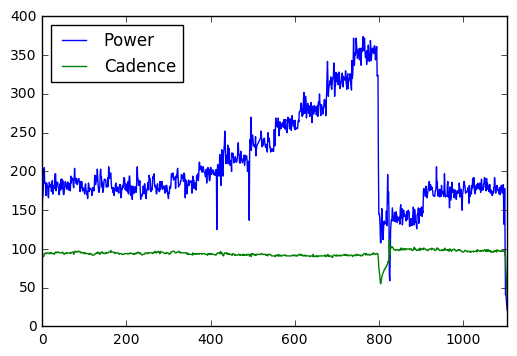

In [98]:
%matplotlib inline
stages.plot(y=['Power', 'Cadence'])

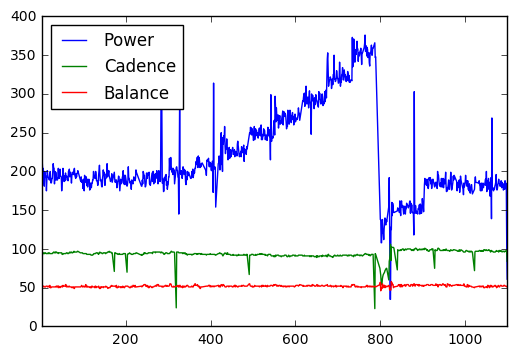

In [99]:
vector.plot(y=['Power', 'Cadence', 'Balance'])

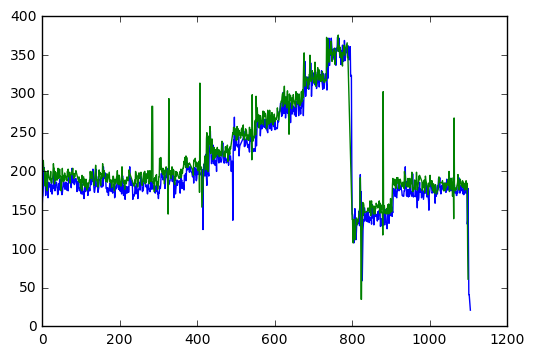

In [104]:
import matplotlib.pyplot as plt
plt.plot(stages.index, stages['Power'],
        vector.index, vector['Power'])

In [103]:
stages.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1105],
           dtype='int64', length=1094)